<a href="https://colab.research.google.com/github/leonardoub/SCRIPT_PALERMO/blob/master/Network_regression_ST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import seaborn as sns

#Load data

In [3]:
#load data from Drive
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


In [0]:
train_dataset_path = '/gdrive/My Drive/AIM_PA/database_training2.csv'
test_dataset_path = '/gdrive/My Drive/AIM_PA/database_nostro_without_nan.csv'

In [0]:
df_train = pd.read_csv(train_dataset_path)
df_test = pd.read_csv(test_dataset_path)

In [0]:
df_train.rename(columns={'Survival.time (months)':'Surv_time_months'}, inplace=True)

In [0]:
df_test.rename(columns={'Survival.time (months)':'Surv_time_months'}, inplace=True)

In [0]:
df_train.rename(columns={'Overall.Stage':'Overall_Stage'}, inplace=True)
df_test.rename(columns={'Overall.Stage':'Overall_Stage'}, inplace=True)

In [0]:
train_data = df_train.drop(['Histology', 'Surv_time_months', 'OS', 'deadstatus.event','Overall_Stage'], axis=1)

In [0]:
test_data = df_test.drop(['Histology', 'Surv_time_months', 'OS', 'deadstatus.event','Overall_Stage'], axis=1)

In [0]:
train_targets = df_train.Surv_time_months

In [0]:
test_targets = df_test.Surv_time_months

#Z score dei dati

In [0]:
mean = train_data.mean(axis=0)
train_data_stand = train_data - mean
std = train_data.std(axis=0)
train_data_stand /= std

In [0]:
test_data_stand = test_data - mean
test_data_stand /= std

#PCA

In [0]:
from sklearn.decomposition import PCA

In [0]:
pca = PCA(n_components=0.9, svd_solver='full')

In [0]:
pca.fit(train_data_stand)

PCA(copy=True, iterated_power='auto', n_components=0.9, random_state=None,
    svd_solver='full', tol=0.0, whiten=False)

In [0]:
train_data_stand_pca = pca.transform(train_data_stand)
test_data_stand_pca = pca.transform(test_data_stand)

In [0]:
train_data_stand_pca.shape

(131, 9)

#Building Network

In [0]:
from keras import models

Using TensorFlow backend.


In [0]:
from keras import layers

In [0]:
def build_model():
  model = models.Sequential()
  model.add(layers.Dense(5, activation='relu', input_shape=(9,)))
  model.add(layers.Dense(1))
  model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
  return model

Note that you compile the network with the mse loss function—mean squared error,
the square of the difference between the predictions and the targets. This is a widely
used loss function for regression problems.



You’re also monitoring a new metric during training: mean absolute error (MAE). It’s
the absolute value of the difference between the predictions and the targets. For
instance, an MAE of 0.5 on this problem would mean your predictions are off by $500
on average.

#K-Fold

In [0]:
from sklearn.model_selection import KFold

In [0]:
kf = KFold(n_splits=3, shuffle=True, random_state=1)
kf.get_n_splits(train_data_stand_pca, train_targets)

3

In [0]:
for train_index, test_index in kf.split(train_data_stand_pca, train_targets):
    print("TRAIN:", train_index, "TEST:", test_index)

TRAIN: [  0   1   3   6   7   8   9  10  11  13  14  15  16  18  19  20  21  22
  23  24  25  26  27  28  29  30  32  34  36  37  38  39  41  43  47  49
  50  52  57  60  61  63  64  65  67  68  69  70  71  72  74  76  77  78
  79  81  83  84  86  87  88  90  92  94  95  96  99 100 101 103 105 106
 107 108 109 112 113 115 117 119 120 122 123 125 127 129 130] TEST: [  2   4   5  12  17  31  33  35  40  42  44  45  46  48  51  53  54  55
  56  58  59  62  66  73  75  80  82  85  89  91  93  97  98 102 104 110
 111 114 116 118 121 124 126 128]
TRAIN: [  0   1   2   4   5   6   7   8   9  11  12  13  14  16  17  18  20  22
  25  28  29  31  33  35  37  40  42  44  45  46  48  50  51  53  54  55
  56  57  58  59  60  61  62  63  64  66  68  71  72  73  75  76  79  80
  81  82  84  85  86  87  88  89  91  93  94  96  97  98 101 102 104 105
 106 107 109 110 111 114 116 117 118 119 121 124 125 126 128] TEST: [  3  10  15  19  21  23  24  26  27  30  32  34  36  38  39  41  43  47
  49  52  65 

In [0]:
num_epochs = 100
all_mae_histories = []
all_mae_val_histories = []
all_loss_histories = []
all_loss_val_histories = []

for train_index, val_index in kf.split(train_data_stand_pca, train_targets):
  partial_train_data = np.array([train_data_stand_pca[i] for i in train_index])
  partial_train_targets = np.array([train_targets[i] for i in train_index])
  
  val_data = np.array([train_data_stand_pca[i] for i in val_index])
  val_targets = np.array([train_targets[i] for i in val_index])

  model = build_model()
  history = model.fit(partial_train_data, partial_train_targets, validation_data=(val_data, val_targets), 
                      epochs= num_epochs, batch_size=1)
  
  mae_history = history.history['mean_absolute_error']
  all_mae_histories.append(mae_history)

  mae_val_history = history.history['val_mean_absolute_error']
  all_mae_val_histories.append(mae_val_history)

  loss_history = history.history['loss']
  all_loss_histories.append(loss_history)

  loss_val_history = history.history['val_loss']
  all_loss_val_histories.append(loss_val_history)


Train on 87 samples, validate on 44 samples
Epoch 1/100
87/87 [==============================] - 0s 3ms/step - loss: 791.4550 - mean_absolute_error: 22.5015 - val_loss: 588.9983 - val_mean_absolute_error: 18.7071
Epoch 2/100
87/87 [==============================] - 0s 1ms/step - loss: 777.3159 - mean_absolute_error: 22.1143 - val_loss: 572.3977 - val_mean_absolute_error: 18.2230
Epoch 3/100
87/87 [==============================] - 0s 1ms/step - loss: 765.1585 - mean_absolute_error: 21.7286 - val_loss: 557.5416 - val_mean_absolute_error: 17.7725
Epoch 4/100
87/87 [==============================] - 0s 1ms/step - loss: 752.2143 - mean_absolute_error: 21.3920 - val_loss: 542.3866 - val_mean_absolute_error: 17.2955
Epoch 5/100
87/87 [==============================] - 0s 1ms/step - loss: 740.3229 - mean_absolute_error: 21.1075 - val_loss: 528.4569 - val_mean_absolute_error: 16.8781
Epoch 6/100
87/87 [==============================] - 0s 1ms/step - loss: 728.6624 - mean_absolute_error: 20.860

In [0]:
history_dict = history.history

In [0]:
history_dict.keys()

dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error'])

In [0]:
average_mae_val_history = [np.mean([x[i] for x in all_mae_val_histories]) for i in range(num_epochs)]
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]
average_loss_val_history = [np.mean([x[i] for x in all_loss_val_histories]) for i in range(num_epochs)]
average_loss_history = [np.mean([x[i] for x in all_loss_histories]) for i in range(num_epochs)]

#Plotting training and validation mae

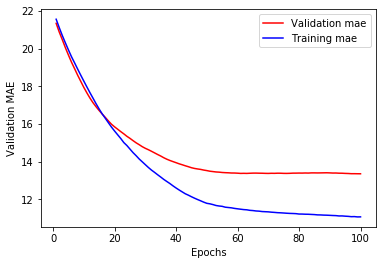

In [0]:
import matplotlib.pyplot as plt
plt.plot(range(1, len(average_mae_val_history) + 1), average_mae_val_history, 'r', label='Validation mae')
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history, 'b', label='Training mae')
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.legend()
plt.show()


#Plotting training and validation loss

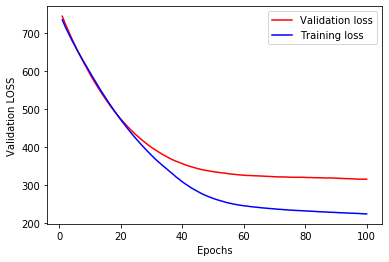

In [0]:
import matplotlib.pyplot as plt
plt.plot(range(1, len(average_loss_val_history) + 1), average_loss_val_history, 'r', label='Validation loss')
plt.plot(range(1, len(average_loss_history) + 1), average_loss_history, 'b', label='Training loss')
plt.xlabel('Epochs')
plt.ylabel('Validation LOSS')
plt.legend()
plt.show()

#Test model


In [0]:
model.fit(train_data_stand_pca, train_targets, epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data_stand_pca, test_targets)

34/34 [==============================] - 0s 62us/step


In [0]:
test_mae_score

12.64631669661578

#Features correlate con l'aspettativa di vita

Cerchiamo le features che correlano meglio con l'aspettativa di vita

In [0]:
train_data = df_train.drop(['Histology', 'OS', 'deadstatus.event','Overall_Stage'], axis=1)

Consideriamo train_data contenente anche 'Surv_time_months'. Calcoliamo la matrice di correlazione.

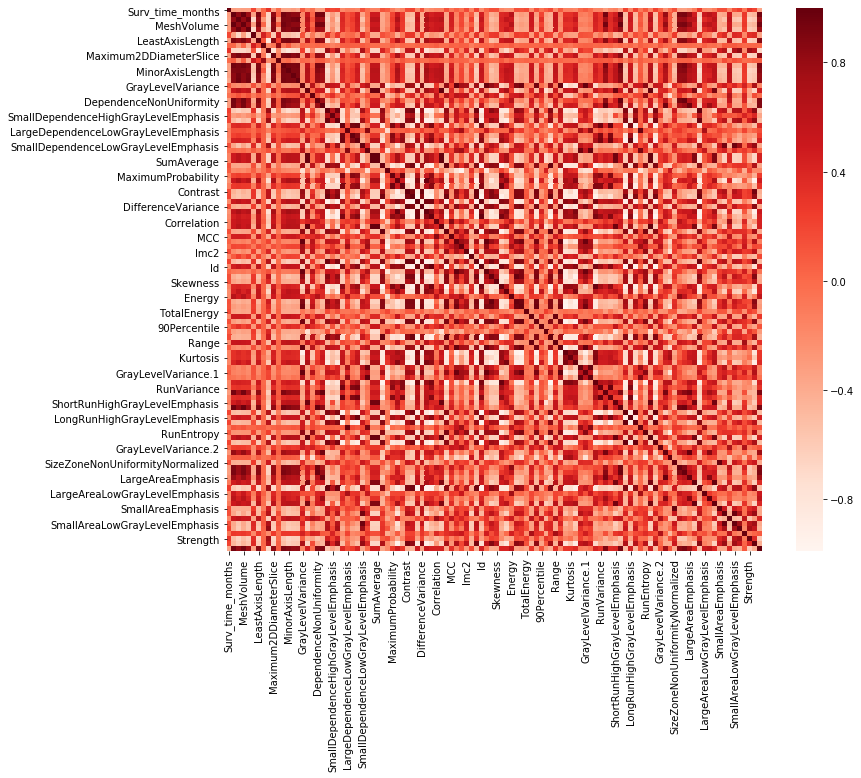

In [17]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = train_data.corr()
sns.heatmap(cor, cmap=plt.cm.Reds)
plt.show()

In [0]:
#Correlation with output variable
cor_target = abs(cor["Surv_time_months"])

In [19]:
cor_target

Surv_time_months     1.000000
VoxelVolume          0.318936
Maximum3DDiameter    0.334456
MeshVolume           0.318857
MajorAxisLength      0.319466
                       ...   
Coarseness           0.236936
Complexity           0.071161
Strength             0.305331
Contrast.1           0.202746
Busyness             0.354545
Name: Surv_time_months, Length: 108, dtype: float64

In [20]:
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.3]
relevant_features

Surv_time_months            1.000000
VoxelVolume                 0.318936
Maximum3DDiameter           0.334456
MeshVolume                  0.318857
MajorAxisLength             0.319466
LeastAxisLength             0.332525
SurfaceVolumeRatio          0.308066
Maximum2DDiameterSlice      0.331666
SurfaceArea                 0.346001
MinorAxisLength             0.346330
Maximum2DDiameterColumn     0.311450
Maximum2DDiameterRow        0.371979
DependenceNonUniformity     0.318601
GrayLevelNonUniformity      0.301370
GrayLevelNonUniformity.1    0.300326
RunLengthNonUniformity      0.317132
SizeZoneNonUniformity       0.319172
GrayLevelNonUniformity.2    0.327871
Strength                    0.305331
Busyness                    0.354545
Name: Surv_time_months, dtype: float64

 However this is not the end of the process. One of the assumptions of linear regression is that the independent variables need to be uncorrelated with each other. If these variables are correlated with each other, then we need to keep only one of them and drop the rest.

In [0]:
relevant_features_list = list(relevant_features.index)

In [39]:
len(relevant_features_list)

20

Creaiamo un dataframe contente solo le features correlate con il 'Surv_time_months'


In [0]:
train_data_correlated = train_data[train_data.columns.intersection(relevant_features_list)]

In [23]:
train_data_correlated.drop('Surv_time_months', axis=1, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [40]:
train_data_correlated.shape

(131, 19)

In [0]:
#create a positive correlation matrix
corr_df = train_data_correlated.corr().abs()

In [0]:
#create and apply mask
mask = np.triu(np.ones_like(corr_df, dtype=bool))

In [26]:
mask

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [False,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [False, False,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [False, False, False,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [False, False, False, False,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [False, False, False, False, False,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [False, False, False, False, False, False,  T

In [0]:
tri_df = corr_df.mask(mask)

In [28]:
tri_df

,VoxelVolume,Maximum3DDiameter,MeshVolume,MajorAxisLength,LeastAxisLength,SurfaceVolumeRatio,Maximum2DDiameterSlice,SurfaceArea,MinorAxisLength,Maximum2DDiameterColumn,Maximum2DDiameterRow,DependenceNonUniformity,GrayLevelNonUniformity,GrayLevelNonUniformity.1,RunLengthNonUniformity,SizeZoneNonUniformity,GrayLevelNonUniformity.2,Strength,Busyness
VoxelVolume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Maximum3DDiameter,0.821982,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MeshVolume,0.999999,0.821800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MajorAxisLength,0.785606,0.964760,0.785457,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LeastAxisLength,0.898913,0.812696,0.898705,0.740991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SurfaceVolumeRatio,0.679146,0.683336,0.678962,0.609701,0.823132,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Maximum2DDiameterSlice,0.832976,0.917765,0.832789,0.865958,0.867676,0.759756,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SurfaceArea,0.950756,0.911623,0.950769,0.888151,0.893055,0.677085,0.899902,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MinorAxisLength,0.889105,0.901223,0.888978,0.848934,0.914366,0.793887,0.933821,0.933720,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Maximum2DDiameterColumn,0.838170,0.940584,0.838067,0.917987,0.840928,0.721090,0.854481,0.911587,0.903020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
#Find columns that meet threshold
to_drop = [c for c in tri_df.columns if any(tri_df[c]>0.80)]
to_drop

['VoxelVolume',
 'Maximum3DDiameter',
 'MeshVolume',
 'MajorAxisLength',
 'LeastAxisLength',
 'Maximum2DDiameterSlice',
 'SurfaceArea',
 'MinorAxisLength',
 'Maximum2DDiameterColumn',
 'Maximum2DDiameterRow',
 'DependenceNonUniformity',
 'GrayLevelNonUniformity',
 'GrayLevelNonUniformity.1',
 'RunLengthNonUniformity',
 'SizeZoneNonUniformity',
 'GrayLevelNonUniformity.2']

The reason we used the mask to set half of the matrox to NA value is that we eant to avoid removing both features when thay have a strong correlation. 

In [0]:
#Drop those columns
train_data_correlated_reduced = train_data_correlated.drop(to_drop, axis=1)

In [38]:
train_data_correlated_reduced.shape

(131, 3)

funziona bene, però bisogna stare attenti a basarsi unicamente sul coefficiente di correlazione. Se y = x^2, x e y risulteranno scorrelate secondo il coeffiente di correlazione di Pearson.

In [32]:
train_data_correlated_reduced

,SurfaceVolumeRatio,Strength,Busyness
0,0.199752,1.153806,1.306338
1,0.356577,2.266070,0.253533
2,0.242519,1.238883,0.611772
3,0.234970,1.157976,0.564313
4,0.159206,0.390430,1.804351
...,...,...,...
126,0.214251,1.669748,0.768631
127,0.255458,0.680747,1.374614
128,0.143462,0.965192,1.584828
129,0.432954,2.407473,0.249712


Le features che correlano meglio con il 'Surv_time_months' e sono scorrelate tra loro sono: SurfaceVolumeRatio, Strength e	Busyness. Il numero ovviamente dipende dalle soglie impostate.

##Prova con train_data_correlated

###Z score dei dati

In [0]:
mean = train_data_correlated.mean(axis=0)
train_data_correlated_stand = train_data_correlated - mean
std = train_data_correlated.std(axis=0)
train_data_correlated_stand /= std

In [0]:
#test_data_stand = test_data - mean
#test_data_stand /= std

#Building Network

In [51]:
from keras import models

Using TensorFlow backend.


In [0]:
from keras import layers

In [0]:
def build_model():
  model = models.Sequential()
  model.add(layers.Dense(8, activation='relu', input_shape=(19,)))
  model.add(layers.Dense(1))
  model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
  return model

Note that you compile the network with the mse loss function—mean squared error,
the square of the difference between the predictions and the targets. This is a widely
used loss function for regression problems.



You’re also monitoring a new metric during training: mean absolute error (MAE). It’s
the absolute value of the difference between the predictions and the targets. For
instance, an MAE of 0.5 on this problem would mean your predictions are off by $500
on average.

###K-Fold

In [0]:
from sklearn.model_selection import KFold

In [55]:
kf = KFold(n_splits=3, shuffle=True, random_state=1)
kf.get_n_splits(train_data_correlated_stand, train_targets)

3

In [56]:
for train_index, test_index in kf.split(train_data_correlated_stand, train_targets):
    print("TRAIN:", train_index, "TEST:", test_index)

TRAIN: [  0   1   3   6   7   8   9  10  11  13  14  15  16  18  19  20  21  22
  23  24  25  26  27  28  29  30  32  34  36  37  38  39  41  43  47  49
  50  52  57  60  61  63  64  65  67  68  69  70  71  72  74  76  77  78
  79  81  83  84  86  87  88  90  92  94  95  96  99 100 101 103 105 106
 107 108 109 112 113 115 117 119 120 122 123 125 127 129 130] TEST: [  2   4   5  12  17  31  33  35  40  42  44  45  46  48  51  53  54  55
  56  58  59  62  66  73  75  80  82  85  89  91  93  97  98 102 104 110
 111 114 116 118 121 124 126 128]
TRAIN: [  0   1   2   4   5   6   7   8   9  11  12  13  14  16  17  18  20  22
  25  28  29  31  33  35  37  40  42  44  45  46  48  50  51  53  54  55
  56  57  58  59  60  61  62  63  64  66  68  71  72  73  75  76  79  80
  81  82  84  85  86  87  88  89  91  93  94  96  97  98 101 102 104 105
 106 107 109 110 111 114 116 117 118 119 121 124 125 126 128] TEST: [  3  10  15  19  21  23  24  26  27  30  32  34  36  38  39  41  43  47
  49  52  65 

In [57]:
num_epochs = 100
all_mae_histories = []
all_mae_val_histories = []
all_loss_histories = []
all_loss_val_histories = []

for train_index, val_index in kf.split(train_data_correlated_stand, train_targets):
  partial_train_data = np.array([train_data_correlated_stand[i] for i in train_index])
  partial_train_targets = np.array([train_targets[i] for i in train_index])
  
  val_data = np.array([train_data_correlated_stand[i] for i in val_index])
  val_targets = np.array([train_targets[i] for i in val_index])

  model = build_model()
  history = model.fit(partial_train_data, partial_train_targets, validation_data=(val_data, val_targets), 
                      epochs= num_epochs, batch_size=1)
  
  mae_history = history.history['mean_absolute_error']
  all_mae_histories.append(mae_history)

  mae_val_history = history.history['val_mean_absolute_error']
  all_mae_val_histories.append(mae_val_history)

  loss_history = history.history['loss']
  all_loss_histories.append(loss_history)

  loss_val_history = history.history['val_loss']
  all_loss_val_histories.append(loss_val_history)









Train on 87 samples, validate on 44 samples
Epoch 1/100





87/87 [==============================] - 1s 6ms/step - loss: 751.7221 - mean_absolute_error: 21.4353 - val_loss: 538.6561 - val_mean_absolute_error: 16.9738
Epoch 2/100
87/87 [==============================] - 0s 1ms/step - loss: 714.7287 - mean_absolute_error: 20.7749 - val_loss: 519.0401 - val_mean_absolute_error: 16.4803
Epoch 3/100
87/87 [==============================] - 0s 1ms/step - loss: 681.3773 - mean_absolute_error: 20.2094 - val_loss: 497.7883 - val_mean_absolute_error: 15.9996
Epoch 4/100
87/87 [==============================] - 0s 1ms/step - loss: 647.7272 - mean_absolute_error: 19.5602 - val_loss: 477.3528 - val_mean_absolute_error: 15.5468
Epoch 5/100
87/87 [==============================] - 0s 1ms/step - loss: 613.1599 - mean_absolute_error: 18.8636 - val_loss: 456.4633 - val_mean_absolute_error: 15.0548
Epoch 6/100
87/87 [==============================] - 0s 1ms/step - loss: 573.0561 - mean_absolute_e

In [0]:
history_dict = history.history

In [59]:
history_dict.keys()

dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error'])

In [0]:
average_mae_val_history = [np.mean([x[i] for x in all_mae_val_histories]) for i in range(num_epochs)]
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]
average_loss_val_history = [np.mean([x[i] for x in all_loss_val_histories]) for i in range(num_epochs)]
average_loss_history = [np.mean([x[i] for x in all_loss_histories]) for i in range(num_epochs)]

###Plotting training and validation mae

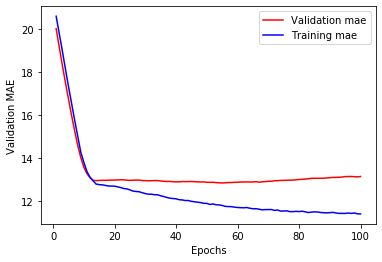

In [61]:
import matplotlib.pyplot as plt
plt.plot(range(1, len(average_mae_val_history) + 1), average_mae_val_history, 'r', label='Validation mae')
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history, 'b', label='Training mae')
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.legend()
plt.show()


#Plotting training and validation loss

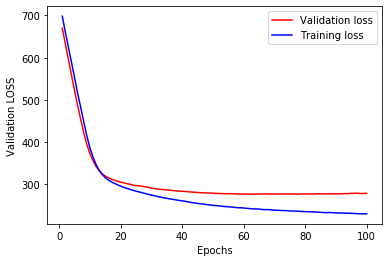

In [62]:
import matplotlib.pyplot as plt
plt.plot(range(1, len(average_loss_val_history) + 1), average_loss_val_history, 'r', label='Validation loss')
plt.plot(range(1, len(average_loss_history) + 1), average_loss_history, 'b', label='Training loss')
plt.xlabel('Epochs')
plt.ylabel('Validation LOSS')
plt.legend()
plt.show()